# Imports

In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
import myOptimizers as optims
import os
import importlib

# Function Definitions

In [2]:
# Weight initialisation
def init_random_params(scale, layer_sizes, rs=npr.RandomState(42)):
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

# Activation function
def tanh(x):
    return (2 / (1.0 + np.exp(-2*x))) - 1
    #return np.log(1+np.exp(x))
    #return np.exp(x)

# Returns the NN output AFTER enforcing the boundary condition. This is the wavefunction (wf).
def psi(nnparams, inputs):
    origInput = inputs
    xTilde = (origInput - x0) / (x1 - x0)
    
    for W, b in nnparams:
        outputs = np.dot(inputs, W) + b
        inputs = tanh(outputs)    
        
    # Enforcing the boundary conditions
    return (1-xTilde)*psi0 + xTilde*psi1 + (1-np.exp(xTilde * (1 - xTilde))) * outputs


dpsi = elementwise_grad(psi, 1) # Function for returning first derivative of wf (not used explicitly)
ddpsi = elementwise_grad(dpsi, 1) # Second derivative of wf. 

In [3]:
PRC1 = 20 # Probability regularisation co-efficient for degree 1 (and -1)
PRC2 = PRC1/(2*2) # Probability regularisation co-efficient for degree 2 (and -2)
PRC3 = PRC2/(2*3) # Probability regularisation co-efficient for degree 3 (and -3)
PRC4 = PRC3/(2*4) # Probability regularisation co-efficient for degree 4 (and -4)

def floatStr (Efloat) :
    Eint = int(np.floor(Efloat))
    if Efloat - Eint == 0 :
        return str(int(np.floor(Efloat)))
    else :
        Estr = str(Efloat)
        return str(int(np.floor(Efloat))) + "p" + Estr[Estr.find('.')+1:]

# Objective function
def objective(params, step):
    nnparams = params['nn']
    E = params['E']        
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    
    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    

    return np.mean(diffeq**2) + (1-prob)**2 + (PRC1/prob + PRC1*prob) + \
        (PRC2/prob**2 + PRC2*prob**2) + (PRC3/prob**3 + PRC3*prob**3) + \
        (PRC4/prob**4 + PRC4*prob**4)


trunc = -1
iterList = []
diffeqList = []
diffeqDiffList = []
probList = []
lossList = []
EList = []
# Helper function for callback. Prints the following -
# 1. Iteration no.
# 2. MSE term
# 3. Probability integral
# 4. Loss
# 5. Eigen-energy 
def objectiveDebug (params, step) :
    nnparams = params['nn']
    E = params['E']   
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    mean = np.mean(diffeq**2)  # MSE

    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    

    loss = mean + (1-prob)**2 + (PRC1/prob + PRC1*prob) + \
        (PRC2/prob**2 + PRC2*prob**2) + (PRC3/prob**3 + PRC3*prob**3) + \
        (PRC4/prob**4 + PRC4*prob**4)
    
    iterList.append (step)
    diffeqList.append (mean)
    probList.append (prob)
    lossList.append (loss)
    EList.append (float(params['E']))

    print ("Iteration " + str(step) + "\ndiffeq = " + str(mean) + " prob = " + str(prob))
    print ("loss = " + str(loss) + " E = " + str(params['E']))
    print ("--------------------------------------------------------------")

# Callback function.
def callback(params, step, g):
    global trunc
    global diffeqList
    
    if step % 100 == 0:
        objectiveDebug (params, step)

# Initialisation

In [4]:
psi0 = 0 # Value of first boundary
psi1 = 0 # Value of second boundary
L = 2 # Length of the well
n = 5 # Energy level to be found
scale = 2 # Scale for initialisation
divs = 300 # divisions of the input space

x0 = 0  # Position of first boundary
x1 = L  # Position of second boundary

In [5]:
# Initialising the weights. They usually fall between 0 and 1 which causes the initial wavefunction
# to have a small probability integral over the range. Hence, I've put a scale factor of 2 that changes gives it
# a random (but sizeable) shape so that over the epochs, the probability integral converges to 1.
nnparams = init_random_params(scale/(x1-x0), layer_sizes=[1, 32, 32, 1])

# Intialise a guess eigenvalue to find a true eigenvalue near it
initE = 35.0
params = {'nn': nnparams, 'E': initE}

# Input space
x = np.linspace(x0, x1, divs)[:, None]

# Setting up the name for saving files
name = "n" + str(n)+ "L" + floatStr(L) + "E" + floatStr(float(params['E']))

# Optimization

In [6]:
optims = importlib.reload (optims)
#params = optims.myAdam (grad(objective), params, callback=callback, step_size=0.001, diffeqList=diffeqList, probList=probList, diffeqDiffList = diffeqDiffList)
params = optims.adam (grad(objective), params, callback=callback, step_size=0.001, num_iters=10000)

Iteration 0
diffeq = 568.2723196928183 prob = 1.013412847891081
loss = 620.1562282116683 E = 35.0
--------------------------------------------------------------
Iteration 100
diffeq = 134.01164260289616 prob = 0.4051701409371906
loss = 239.56143463097473 E = 34.91736490782398
--------------------------------------------------------------
Iteration 200
diffeq = 94.12450249080392 prob = 0.4500623265906395
loss = 185.32401817678826 E = 34.83765225834454
--------------------------------------------------------------
Iteration 300
diffeq = 75.30615228784173 prob = 0.45184263019195386
loss = 166.03169048157727 E = 34.75670245004156
--------------------------------------------------------------
Iteration 400
diffeq = 52.876557995456594 prob = 0.4756609005759984
loss = 137.81506218783457 E = 34.68657081019519
--------------------------------------------------------------
Iteration 500
diffeq = 43.74255391635047 prob = 0.5179550813083342
loss = 120.49393361289593 E = 34.62142335049745
---------

Iteration 4600
diffeq = 3.047145156023761 prob = 0.9221516534978494
loss = 55.25185038599329 E = 32.35739297366578
--------------------------------------------------------------
Iteration 4700
diffeq = 2.6841122569900366 prob = 0.9283409678175282
loss = 54.83657731968447 E = 32.27601125727357
--------------------------------------------------------------
Iteration 4800
diffeq = 2.3597087950542823 prob = 0.9340721974190085
loss = 54.46810206230006 E = 32.19590796580574
--------------------------------------------------------------
Iteration 4900
diffeq = 2.070859381497841 prob = 0.9394440131138069
loss = 54.14162787665235 E = 32.11736406918491
--------------------------------------------------------------
Iteration 5000
diffeq = 1.815119112452917 prob = 0.9446658819539948
loss = 53.852667680863185 E = 32.04061907113885
--------------------------------------------------------------
Iteration 5100
diffeq = 1.5877378609040589 prob = 0.9494389934865418
loss = 53.59776579643688 E = 31.965840

Iteration 9200
diffeq = 0.1710602041631772 prob = 0.9978017511401953
loss = 52.04630314816021 E = 30.84303455169576
--------------------------------------------------------------
Iteration 9300
diffeq = 0.1703906588267681 prob = 0.9980784448224489
loss = 52.04557624261695 E = 30.842872917978035
--------------------------------------------------------------
Iteration 9400
diffeq = 0.16892895237070374 prob = 0.9978937423072953
loss = 52.044151968454635 E = 30.842678997984702
--------------------------------------------------------------
Iteration 9500
diffeq = 0.16797028074130368 prob = 0.9978985915851983
loss = 52.04319227004047 E = 30.842642019269448
--------------------------------------------------------------
Iteration 9600
diffeq = 0.16705744094760477 prob = 0.9979235241304552
loss = 52.042274188517744 E = 30.842617011628395
--------------------------------------------------------------
Iteration 9700
diffeq = 0.16632850984897632 prob = 0.9980401527226803
loss = 52.0415215711048 E 

# Plots

In [12]:
replot = 0
if replot == 1 :
    params['E'] = initE
    n = 2
    L = 1
    name = "n" + str(n)+ "L" + floatStr(L) + "E" + floatStr(float(params['E']))

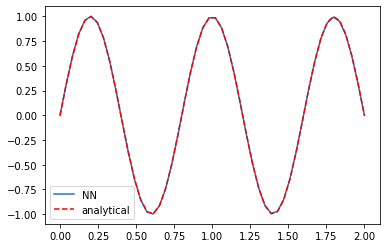

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
x = np.linspace(x0, x1)[:, None]
y = psi(params['nn'], x)

plt.plot(x, y, label='NN')  # Plotting the NN output
plt.plot(x, np.sqrt(2/L) * np.sin(n*np.pi * (x-x0)/L), 'r--', label='analytical')  # Plotting the actual wavefuncion
plt.legend()
plt.savefig (name + "_plot.png")

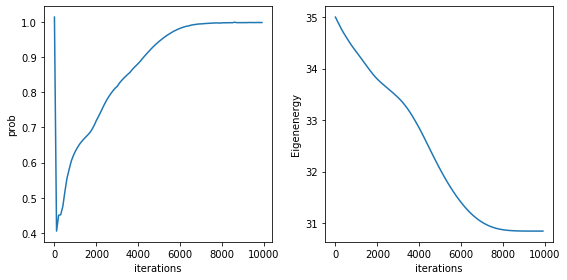

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure (figsize=(8,4))
plt.clf ()

'''
#plt.subplot (1 , 1 , 1)
plt.plot (iterList, probList)
plt.xlabel ('iterations')
plt.ylabel ('prob')
'''

plt.subplot (1, 2, 1)
plt.plot (iterList, probList)
plt.xlabel ('iterations')
plt.ylabel ('prob')

plt.subplot (1, 2, 2)
plt.plot (iterList, EList)
plt.xlabel ('iterations')
plt.ylabel ('Eigenenergy')


'''
plt.subplot (2, 2, 3)
plt.plot (iterList, lossList)
plt.xlabel ('iterations')
plt.ylabel ('loss')

'''

plt.tight_layout()

plt.savefig (name + "_diagProbEig.png")

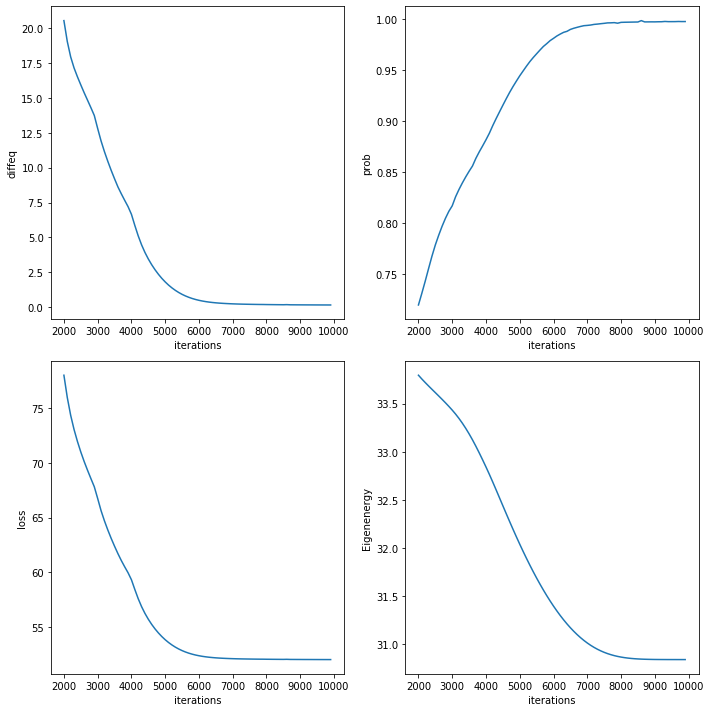

In [10]:
trunc = 20
if trunc != -1 :
    fig = plt.figure (figsize=(10,10))

    plt.subplot (2 , 2 , 1)
    plt.plot (iterList[trunc:], diffeqList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('diffeq')

    plt.subplot (2, 2, 2)
    plt.plot (iterList[trunc:], probList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('prob')

    plt.subplot (2, 2, 3)
    plt.plot (iterList[trunc:], lossList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('loss')

    plt.subplot (2, 2, 4)
    plt.plot (iterList[trunc:], EList[trunc:])
    plt.ylabel ('Eigenenergy')
    plt.xlabel ('iterations')
    plt.tight_layout()

    plt.savefig (name + "_diagTrunc" + str(trunc) + ".png")

# Write to file

In [15]:
outfile = open(name + "_info.txt" , "w")

fstr = "diffeq = " + str(round(diffeqList[-1],8)) + \
"\nprob = " + str(round(probList[-1],8)) + \
"\nloss = " + str(round(lossList[-1],8)) + \
"\neigE = " + str(round(EList[-1],8))

    
outfile.write (fstr)
outfile.close ()